In [1]:
import gpytorch
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib as mpl 

import numpy as np
import torch
import torch.nn as nn
from torch.distributions import Normal, Categorical

from sampling.data import ActiveLearningDataset
from sampling.training import Trainer
from torch.optim import SGD 
from gpytorch.mlls import ExactMarginalLogLikelihood
from torch.utils.data import DataLoader

import ipywidgets
from ipywidgets import interact
import IPython
# If in your browser the figures are not nicely vizualized, change the following line. 
rcParams['font.size'] = 12

import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

In [2]:
class ExactGP(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood=gpytorch.likelihoods.GaussianLikelihood(noise_constraint=gpytorch.constraints.GreaterThan(1e-8))):
        super().__init__(train_x, train_y, likelihood=likelihood) 
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        """Forward computation of GP."""
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    
    @property
    def output_scale(self):
        """Get output scale."""
        return self.covar_module.outputscale
    
    @property
    def length_scale(self):
        """Get length scale."""
        return self.covar_module.base_kernel.lengthscale
    
    @length_scale.setter
    def length_scale(self, value):
        self.covar_module.base_kernel.lengthscale = value 
         
        
class BOpt(nn.Module):
    """Abstract Bayesian Optimization class. ."""
    def __init__(self, gp, x, beta=2.0):
        super().__init__()
        self.gp = gp
        self.gp.eval()
        self.gp.likelihood.eval()
        self.x = x
        self.update_acquisition_function()
    
    def update_gp (self, new_inputs, new_targets):
        """Update GP with new points."""
        inputs = torch.cat((self.gp.train_inputs[0], new_inputs.unsqueeze(-1)), dim=0)
        targets = torch.cat((self.gp.train_targets, new_targets), dim=-1)
        self.gp.set_train_data(inputs, targets, strict=False)
        self.update_acquisition_function()
    
    def get_best_value(self):
        idx = self.gp.train_targets.argmax()
        if len(self.gp.train_targets) == 1:
            xmax, ymax = self.gp.train_inputs[idx], self.gp.train_targets[idx]
        else:
            xmax, ymax = self.gp.train_inputs[0][idx], self.gp.train_targets[idx]
        return xmax, ymax 
        
    def update_acquisition_function(self):
        raise NotImplementedError 
    
    @property 
    def acquisition_function(self):
        return self._acquisition_function 
    
    def forward(self): 
        """Call the algorithm. """
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            y = self.acquisition_function
            max_id = torch.argmax(y)
            next_point = self.x[[[max_id]]]
        return next_point
    
class GPUCB(BOpt):
    def __init__(self, gp, x, beta=2.0):
        self.beta = beta
        super().__init__(gp, x)
    
    def update_acquisition_function(self):        
        pred = self.gp(self.x)
        ucb = pred.mean + self.beta * pred.stddev  # Calculate UCB.
        self._acquisition_function = ucb 
    
class EpsGreedy(BOpt):
    def __init__(self, gp, x, eps=0.1):
        self.eps = eps
        super().__init__(gp, x)
        
    def update_acquisition_function(self):
        x = self.x + self.eps * torch.randn(self.x.shape)
        self._acquisition_function = self.gp(x).mean 
            
class ThompsonSampling(BOpt):
    def update_acquisition_function(self):
        pred = self.gp(self.x)
        self._acquisition_function = pred.sample()
        
class ProbabilityImprovement(BOpt):
    def __init__(self, gp, x, xi=0.01):
        self.xi = xi
        super().__init__(gp, x)
        
    def update_acquisition_function(self):
        xmax, ymax = self.get_best_value()
        out = self.gp(self.x)
        dist = Normal(torch.tensor([0.]), torch.tensor([1.]))
        Z = (out.mean - ymax - self.xi) / out.stddev
        self._acquisition_function = dist.cdf(Z)
        
class ExpectedImprovement(BOpt):
    def __init__(self, gp, x, xi=0.01):
        self.xi = xi
        super().__init__(gp, x)
        
    def update_acquisition_function(self):
        xmax, ymax = self.get_best_value()
        out = self.gp(self.x)
        dist = Normal(torch.tensor([0.]), torch.tensor([1.]))
        Z = (out.mean - ymax - self.xi) / out.stddev 
        idx = out.stddev == 0
        self._acquisition_function = (out.mean - ymax - self.xi) * dist.cdf(Z) + out.stddev * torch.exp(dist.log_prob(Z))
        self._acquisition_function[idx] = 0 
        
class MaxTraceCov(BOpt):
    def update_acquisition_function(self):      
        pred = self.gp(self.x)
        self._acquisition_function = pred.stddev  # Calculate UCB.

class CovSampling(BOpt):
    def update_acquisition_function(self):      
        pred = self.gp(self.x)
        m = Categorical(probs=pred.stddev / pred.stddev.sum())
        self._acquisition_function = torch.zeros_like(self.x)
        self._acquisition_function[m.sample()] = 1
    
class UAR(BOpt):
    def update_acquisition_function(self): 
        p = torch.ones_like(self.x)
        m = Categorical(probs=p / p.sum())
        self._acquisition_function = torch.zeros_like(self.x)
        self._acquisition_function[m.sample()] = 1

In [12]:
def plot_gp(x: torch.Tensor, model: gpytorch.models.GP, num_samples: int, ax) -> None:
    """Plot 1-D GP.

    Parameters
    ----------
    x: points to plot.
    model: GP model.
    num_samples: number of random samples from gp.
    ax: axes where to plot the plot.
    """
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        pred = model(x)
        mean = pred.mean.numpy()
        error = 2 * pred.stddev.numpy()
        true_values = objective_function.func(x).mean.numpy()

    # Plot gp prediction
    ax.fill_between(x, mean - error, mean + error, lw=0, alpha=0.2, color='C0')
        
    # Plot mean
    ax.plot(x, mean, lw=2, color='C0')
    
    # Plot ground-truth
    ax.plot(x, true_values, '--', color='k')
    
    # Plot data
    ax.plot(model.train_inputs[0].numpy(),
            model.train_targets.numpy(),
            '.', markeredgewidth=2, markersize=15, color='C1')

    # Plot samples.
    for _ in range(num_samples):
        plt.plot(x.numpy(), pred.sample().numpy())
    
    ax.set_xlim(x[0], x[-1])
    ax.set_ylim(-3, 3)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel(r"Input $x$")
    ax.set_ylabel(r"Objective $f(x)$")
    
def plot_acquisition_function(x: torch.Tensor, y: torch.Tensor, ax, ylim: tuple = (-3, 3)) -> None:
    """Plot 1-D Acquisition function.

    Parameters
    ----------
    x: points to plot.
    y: values of acquisition_function.
    """
    max_idx = torch.argmax(y)
    next_x, next_y = x[max_idx], y[max_idx]
    
    with torch.no_grad():
        # Plot function
        ax.plot(x.detach().numpy(), y.detach().numpy())

        # Plot maximizer
        ax.plot(next_x.detach().numpy(), next_y.detach().numpy(), 'ko', markersize=15, label="Next Point")
    
    ax.legend(loc="lower right")
    ax.set_xlim(x[0], x[-1])
    ax.set_ylim(*ylim)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel(r"Input $x$")
    ax.set_ylabel(r"Acquisition Function")

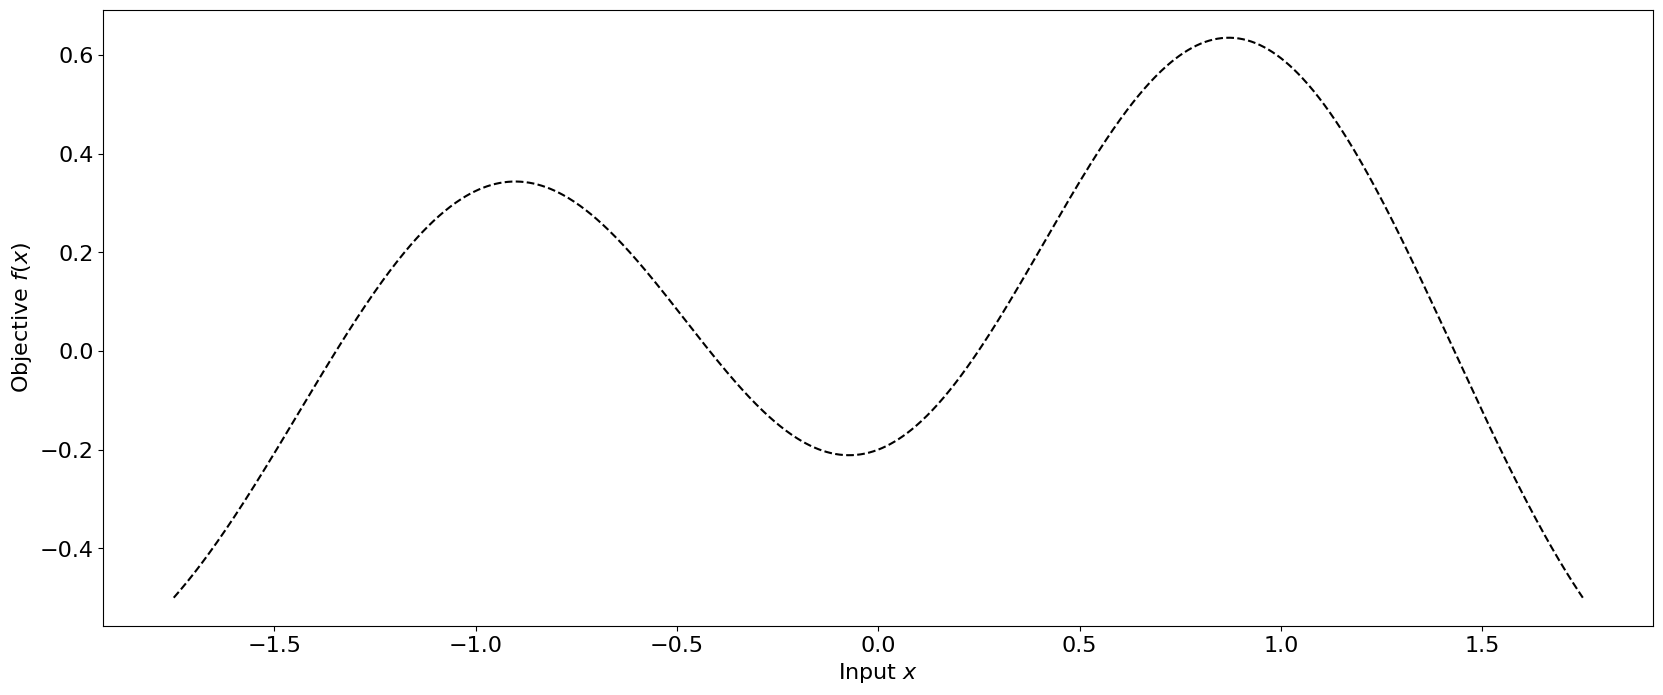

In [13]:
# Define objective function
rcParams['figure.figsize'] = (20, 8)
rcParams['font.size'] = 16

X = (torch.tensor([-1., 1., 2.5, 4., 6]) - 2.5) / 2
Y = torch.tensor([-0.5, 0.3, -0.2, .6, -0.5])

NUM_POINTS = 1000
x = (torch.linspace(-1, 6, NUM_POINTS) - 2.5) / 2
likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint=gpytorch.constraints.GreaterThan(1e-8))
likelihood.noise_covar.noise = 0.01 ** 2


class ObjectiveFunction(object):
    def __init__(self, gp, noise):
        self.func = gp 
        self.func.eval()
        self.noise = noise
    
    def __call__(self, x):
        out = self.func(x)
        y = out.mean + self.noise * torch.randn(out.mean.shape)
        return y 
        
objective_function = ObjectiveFunction(ExactGP(X, Y, likelihood), noise=0)

fig, ax = plt.subplots(1, 1)
# fig.set_size_inches(5.5/2, 1.5)
with torch.no_grad():
    ax.plot(x, objective_function(x), 'k--')
ax.set_xlabel(r"Input $x$")
ax.set_ylabel(r"Objective $f(x)$")
plt.show()

In [17]:
def run_active(name, beta, lengthscale, epsilon, xi, noise):
    output = ipywidgets.Output()
    
    
    if noise < 1e-4: noise = 1e-4
    objective_function.noise = noise 
    x0 = x[x > -1.4 ][[0]].unsqueeze(-1)
    with torch.no_grad():
        y0 = objective_function(x0).type(torch.get_default_dtype())
    gp = ExactGP(x0, y0, likelihood)
    gp.length_scale = lengthscale
    gp.likelihood.noise = noise ** 2
    
    ylim_aquisition = (-1, 3.)
    if name == "GP-UCB":
        algorithm =  GPUCB(gp, x, beta=beta)
    elif name == "Thompson":
        algorithm = ThompsonSampling(gp, x)
    elif name == "EpsGreedy":
        algorithm = EpsGreedy(gp, x, eps=epsilon)
    elif name == "EI":
        algorithm = ExpectedImprovement(gp, x, xi=xi)
        ylim_aquisition = (-0.4, 1.1)
    elif name == "PI":
        algorithm = ProbabilityImprovement(gp, x, xi=xi)
        ylim_aquisition = (-0.4, 1.1)
    elif name == "MaxVar":
        algorithm = MaxTraceCov(gp, x)
    elif name == "CovSampling":
        algorithm = CovSampling(gp, x)
    elif name == "Random":
        algorithm = UAR(gp, x)

    ymax = (objective_function.func(x).mean).max()
    regret = []
    max_var = []
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        max_var.append(algorithm.gp(x).stddev.numpy().max() ** 2)
        
    def query_new_point(b):
        with output:
            output.clear_output()
            query_x = algorithm()  # call algorithm to return next query point
            query_y = objective_function(query_x).detach()  # evaluate function on point.
            regret.append((ymax - query_y).detach().numpy())
            algorithm.update_gp(query_x, query_y)  # update GP model. 
            with torch.no_grad(), gpytorch.settings.fast_pred_var():
                max_var.append(algorithm.gp(x).stddev.numpy().max() ** 2)

            plot_algorithm()
        
    def plot_algorithm():
        with output:
            output.clear_output()
            fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(20, 13))

            plot_gp(x, algorithm.gp, num_samples=0, ax=axes[0, 0])
            plot_acquisition_function(x, algorithm.acquisition_function, ax=axes[0, 1], ylim=ylim_aquisition)
            axes[1, 0].set_yticklabels([]) # , which="both"
            if len(regret):
                axes[1, 0].plot(np.cumsum(regret), label="Observed Regret")
                axes[1, 0].plot(range(len(regret)), range(len(regret)), 'k--', label="Linear")
                axes[1, 0].legend(loc="lower right")
                axes[1, 0].set_yticklabels([], minor=True)


            axes[1, 0].set_xticklabels([])
            axes[1, 0].set_xlabel("Num Episode")
            axes[1, 0].set_ylabel("Cumulative Regret")

            axes[1, 1].set_yticklabels([]) # which="both"
            if len(regret):
                axes[1, 1].plot(max_var)
    #             axes[1, 1].legend(loc="lower right")
                axes[1, 1].set_yticklabels([], minor=True)


            axes[1, 1].set_xticklabels([])
            axes[1, 1].set_xlabel("Num Episode")
            axes[1, 1].set_ylabel("Max Pred. Var.")
            axes[1, 1].set_ylim([0, 1])
            plt.show()
        
    # button
    plot_algorithm()
    button = ipywidgets.Button(description="Query New Point")
    button.on_click(query_new_point)
    display(button, output)    

interact(
    run_active,
    name=["GP-UCB", "Thompson", "EpsGreedy", "EI", "PI", "MaxVar", "CovSampling", "Random"],
    beta=ipywidgets.FloatSlider(value=2.0, min=0, max=10, continuous_update=False), 
    lengthscale=ipywidgets.FloatLogSlider(value=0.6, min=-1, max=2, continuous_update=False),
    epsilon=ipywidgets.FloatLogSlider(value=0.1, min=-2, max=0, continuous_update=False),
    xi=ipywidgets.FloatSlider(value=0.01, min=0, max=0.1, step=0.01,continuous_update=False),
    noise=ipywidgets.FloatSlider(value=0.01, min=0.0, max=0.1, step=0.01, continuous_update=False),
);


interactive(children=(Dropdown(description='name', options=('GP-UCB', 'Thompson', 'EpsGreedy', 'EI', 'PI', 'Ma…

## Demo Guide:

#### some explanation
This demo above implement the Bayesian optimization technique with multiple methods. You can see how the algorithm find the best value step by step.
- name: Different method for Bayesian optimization.
- beta: The beta parameter used in GP-UCB method. More details in [work](https://arxiv.org/pdf/0912.3995.pdf)
- lengthscale: The lengthscale parameter used in Gaussian process, note that we use the RBF kernel
- epsilon: The epislon parameter in EpsGreedy algorithm
- xi: The xi parameter in Probability of Improvement (PI); Expected Improvement (EI) algorithm . 
- noise: The Gaussian likelihood noise for Gaussian process
- query new point: Do the bayesian optimization step once and query the next point.
              
                    
#### play around
- Query new point and see the whole optimization process
- Change the method and also try with different method
- Summarize the characteristics of each method.



# Learning and Optimizing

In [18]:
class GPLearner(Trainer):
    def __init__(self, train_set, lr, momentum=0.1, *args, **kwargs):
        super().__init__(train_set, batch_size=len(train_set), *args, **kwargs)
        x, y = train_set.get_observed_data()
        self.model = ExactGP(x, y.squeeze())
        self.optimizer = SGD(self.model.parameters(), lr=lr, momentum=momentum)
        self.mll = ExactMarginalLogLikelihood(self.model.likelihood, self.model)

    def fit(self, *args):
        self.optimizer.zero_grad()
        output = self.model(self.model.train_inputs[0])
        loss = -self.mll(output, self.model.train_targets.detach())
        loss.backward()
        self.optimizer.step()
        return loss

    def predict(self, x, num_samples=1):
        """Output predictive distribution."""
        self.model.eval()
        with torch.no_grad():
            out = self.model(x)
            epistemic_lower, epistemic_upper = out.confidence_region()
            all_lower, all_upper = self.model.likelihood(out).confidence_region()
        return out.mean, all_lower, all_upper, out.mean - out.stddev, out.mean + out.stddev
    
    def update_posterior(self):
        x, y = self.train_set.get_observed_data()
        self.model.set_train_data(x, y.squeeze(), strict=False)

    def sample(self, x):
        """Sample the function at values x."""
        with torch.no_grad():
            out = self.model(x)
            return out.sample()

class ActiveLearning(nn.Module):
    """Abstract Bayesian Optimization class. ."""
    def __init__(self, learner):
        super().__init__()
        
        self.learner = learner
        try:
            self.learner.model.eval()
        except AttributeError:
            pass 
        self.x = self.learner.train_set.x
        self.y = self.learner.train_set.y 
        self.update_acquisition_function()
    
    def update_model(self, new_idx):
        """Update GP with new points."""
        self.learner.train_set.query_index(new_idx)
        self.learner.train_loader = DataLoader(
            self.learner.train_set, batch_size=len(self.learner.train_set), shuffle=True
        )
        try:
            self.learner.update_posterior()
        except AttributeError:
            pass 
        try:
            self.learner.model.eval()
        except AttributeError:
            pass 
        self.update_acquisition_function()
        
    def train(self, num_epochs=1):
        try:
            self.learner.model.train()
        except AttributeError:
            pass 
        self.learner.train(num_epochs=num_epochs)
        try:
            self.learner.model.eval()
        except AttributeError:
            pass 
        self.update_acquisition_function()
    
    def get_best_value(self):
        x, y = self.learner.train_set.get_observed_data()
        idx = y.argmax()
        return x[idx], y[idx]
        
    def update_acquisition_function(self):
        raise NotImplementedError 
    
    @property 
    def acquisition_function(self):
        return self._acquisition_function 
    
    def forward(self): 
        """Call the algorithm. """
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            y = self.acquisition_function
            max_idx = torch.argmax(y)
        return max_idx
    
class AUCB(ActiveLearning):
    def __init__(self, learner, beta=2.0):
        self.beta = beta
        super().__init__(learner)
    
    def update_acquisition_function(self):        
        pred = self.learner.predict_normal(self.x)
        ucb = pred.mean + self.beta * pred.stddev  # Calculate UCB.
        self._acquisition_function = ucb 
    
class AEpsGreedy(ActiveLearning):
    def __init__(self, learner, eps=0.1):
        self.eps = eps
        super().__init__(learner)
        
    def update_acquisition_function(self):
        x = self.x + self.eps * torch.randn(self.x.shape)
        self._acquisition_function = self.learner.predict_normal(x).mean 
            
class AThompsonSampling(ActiveLearning):
    def update_acquisition_function(self):
        self._acquisition_function = self.learner.sample(self.x)
        
class AProbabilityImprovement(ActiveLearning):
    def __init__(self, learner, xi=0.01):
        self.xi = xi
        super().__init__(learner)
        
    def update_acquisition_function(self):
        xmax, ymax = self.get_best_value()
        out = self.learner.predict_normal(self.x)
        dist = Normal(torch.tensor([0.]), torch.tensor([1.]))
        Z = (out.mean - ymax - self.xi) / out.stddev
        self._acquisition_function = dist.cdf(Z)
        
class AExpectedImprovement(ActiveLearning):
    def __init__(self, learner, xi=0.01):
        self.xi = xi
        super().__init__(learner)
        
    def update_acquisition_function(self):
        xmax, ymax = self.get_best_value()
        out = self.learner.predict_normal(self.x)
        dist = Normal(torch.tensor([0.]), torch.tensor([1.]))
        Z = (out.mean - ymax - self.xi) / out.stddev 
        idx = out.stddev == 0
        self._acquisition_function = (out.mean - ymax - self.xi) * dist.cdf(Z) + out.stddev * torch.exp(dist.log_prob(Z))
        self._acquisition_function[idx] = 0 
        
class AMaxTraceCov(ActiveLearning):
    def update_acquisition_function(self):      
        pred = self.learner.predict_normal(self.x)
        self._acquisition_function = pred.stddev  # Calculate UCB.

class ACovSampling(ActiveLearning):
    def update_acquisition_function(self):      
        pred = self.learner.predict_normal(self.x)
        m = Categorical(probs=(pred.stddev).flatten() / (pred.stddev.sum()).flatten())
        self._acquisition_function = torch.zeros_like(self.x)
        self._acquisition_function[m.sample()] = 1
    
class AUAR(ActiveLearning):
    def update_acquisition_function(self): 
        p = torch.ones_like(self.x.flatten())
        m = Categorical(probs=p / p.sum())
        self._acquisition_function = torch.zeros_like(self.x)
        self._acquisition_function[m.sample()] = 1


In [21]:
from sampling.training import (
    SGDLearner, SGLDLearner, MALALearner, SWAGLearner, EnsembleLearner, 
    BootstrapEnsembleLearner, DropoutLearner, BayesBackPropLearner,
    FsvgdLearner
)
from IPython.display import display


def plot_predictions(algorithm, ax, num_samples=1, title=""):
    ax.plot(algorithm.x.detach(), objective_function.func(algorithm.x).mean.detach(), 'k--', label="True Function")
    x = algorithm.x
    out = algorithm.learner.predict_normal(x)
    ax.plot(x.squeeze().detach(), out.mean.squeeze().detach(), '-', color="tab:blue", lw=2, label='Mean Prediction')
    ax.fill_between(
        x.squeeze().detach(), 
        (out.mean - out.stddev).squeeze().detach(), 
        (out.mean + out.stddev).squeeze().detach(),
        alpha=0.2,
        label="Confidence Interval"
    )
    x, y = algorithm.learner.train_set.get_observed_data()
    ax.plot(x.detach(), y.detach(), '.', markersize=15, color="tab:orange", label="Data")
    ax.legend(loc="upper left")
    ax.set_ylim([-3, 3])

def run_active_lerning(learner_name, alg_name, beta, epsilon, xi, noise):
    output = ipywidgets.Output()
    
    # init objective
    x = (torch.linspace(-1, 6, NUM_POINTS) - 2.5) / 2
    objective_function = ObjectiveFunction(ExactGP(X, Y, likelihood), noise=noise)
    dataset = ActiveLearningDataset(x.unsqueeze(-1), objective_function(x).unsqueeze(-1))
    dataset.query_index(NUM_POINTS // 2)
    dataset.query_index(torch.where(x > -0.8)[0][0].item())
    if learner_name == "GP":
        learner = GPLearner(dataset, lr=0.1)
        learner.model.likelihood.noise = 1e-3
        learner.model.length_scale = 0.4
        num_epochs = 200
    elif learner_name == "SWAG":
        learner = SWAGLearner(
            train_set=dataset,
            batch_size=len(dataset),
            lr=0.005, weight_decay=1e-3, burn_in=5, sub_sample=1,deterministic=True
        ) 
        num_epochs = 100
        learner.train(num_epochs)
    elif learner_name == "Ensemble":
        learner = EnsembleLearner(
            dataset, batch_size=len(dataset),
            num_heads=5, lr=0.001, weight_decay=1e-4,
        ) 
        num_epochs = 500
    elif learner_name == "BootstrapEnsemble":
        learner = BootstrapEnsembleLearner(
            dataset, batch_size=len(dataset),
            num_heads=5, lr=0.005, weight_decay=1e-6,deterministic=True
        ) 
        num_epochs = 200
    elif learner_name == "Dropout":
        learner = DropoutLearner(
            train_set=dataset, batch_size=len(dataset),
            dropout_p=0.05, lr=0.005, weight_decay=1e-2,
        ) 
        num_epochs = 40 
    elif learner_name == "SGLD":
        num_epochs=2000
        learner = SGLDLearner(
            train_set=dataset,
            batch_size=len(dataset),
            lr=1e-3, weight_decay=1e-3, num_iter=num_epochs,deterministic=True,
            burn_in=200, sub_sample=100, max_size=10,
    ) 
        learner.train(num_epochs)
    elif learner_name == "MALA":
        num_epochs=2000
        learner = MALALearner(
            train_set=dataset,
            batch_size=len(dataset),
            lr=2e-4, weight_decay=1e-3, num_iter=num_epochs,
            burn_in=5, sub_sample=30, max_size=100,
    ) 
        learner.train(num_epochs) 
    elif learner_name == "SGD": 
        num_epochs = 40
        learner = SGDLearner(train_set=dataset, lr=0.001, batch_size=len(dataset), weight_decay=0.01)
    elif learner_name == 'FSVGD':
        num_epochs = 500
        learner = FsvgdLearner(
            train_set=dataset, batch_size=len(dataset),
            num_heads=10, lr=1e-3, weight_decay=1e-2,
            svgd_bandwidth=0.2
        )
        
    if alg_name == "UCB":
        algorithm =  AUCB(learner, beta=beta)
    elif alg_name == "Thompson":
        algorithm = AThompsonSampling(learner)
    elif alg_name == "EpsGreedy":
        algorithm = AEpsGreedy(learner, eps=epsilon)
    elif alg_name == "EI":
        algorithm = AExpectedImprovement(learner, xi=xi)
    elif alg_name == "PI":
        algorithm = AProbabilityImprovement(learner, xi=xi)
    elif alg_name == "MaxTrace":
        algorithm = AMaxTraceCov(learner)
    elif alg_name == "CovSampling":
        algorithm = ACovSampling(learner)
    elif alg_name == "Random":
        algorithm = AUAR(learner)

    def plot_algorithm():
        with output:
            output.clear_output()
            fig, axes = plt.subplots(ncols=2, nrows=1)

            plot_predictions(algorithm, num_samples=0, ax=axes[0])
            plot_acquisition_function(x, algorithm.acquisition_function, ax=axes[1])

            plt.show()
        
    def query_new_point(b):
        idx = algorithm().item() # call algorithm to return next query point
        algorithm.update_model(idx)  # update GP model. 
        plot_algorithm()
        
    def query_random_point(b):
        idx = np.random.choice(NUM_POINTS)  # query a random point
        algorithm.update_model(idx)  # update GP model. 
        plot_algorithm()
    
    def train(b):
        algorithm.train(num_epochs=num_epochs)
        plot_algorithm()
        
    plot_algorithm()
    # buttons
    button = ipywidgets.Button(description="Query New Point")
    button.on_click(query_new_point)
    button2 = ipywidgets.Button(description="Train")
    button2.on_click(train)
    button3 = ipywidgets.Button(description="Query Random Point")
    button3.on_click(query_random_point)
    
    display(button, button2, button3, output)
    

interact(
    run_active_lerning,
    learner_name=["GP",  "BootstrapEnsemble", "SGLD", "FSVGD"], #SGLD, Ensemble, SGD,  "Dropout", "SWAG",
    alg_name=["UCB", "Thompson", "EpsGreedy", "EI", "PI", "MaxTrace", "CovSampling", "Random"],
    beta=ipywidgets.FloatSlider(value=2.0, min=0, max=10, continuous_update=False), 
    epsilon=ipywidgets.FloatLogSlider(value=0.1, min=-2, max=0, continuous_update=False),
    xi=ipywidgets.FloatSlider(value=0.01, min=0, max=0.1, step=0.01,continuous_update=False),
    noise=ipywidgets.FloatSlider(value=0.01, min=0, max=0.1, step=0.01, continuous_update=False),
);

interactive(children=(Dropdown(description='learner_name', options=('GP', 'BootstrapEnsemble', 'SGLD', 'FSVGD'…

## Demo Guide:

#### some explanation
This demo above implement the Bayesian optimization technique combined with also learning process. It means we run the different Bayesian neural network in parallel. You can see how the algorithm find the best value step by step.
- learner_name: Different bayesian neural network variantional inference method
- alg_name: Different method for Bayesian optimization.
- beta: The beta parameter used in GP-UCB method. 
- lengthscale: The lengthscale parameter used in Gaussian process, note that we use the RBF kernel
- epsilon: The epislon parameter in EpsGreedy algorithm
- xi: The xi parameter in Probability of Improvement (PI); Expected Improvement (EI) algorithm . 
- noise: The Gaussian likelihood noise for Gaussian process
- query new point: Do the bayesian optimization step once and query the next point.
- Train: Train the bayesian neural network to learn the true function.
- Query random Point: Instead of running the optimization and get next point by randomly exploring.
    
#### play around
- Think about why we can not keep query new point
- Think about when should we query random point.
- Combine the querying with training and see the whole optimization process
- Change the learning method and also the bayesian optimization techniques
- Summarize the characteristics of each method combination.



# Classification

In [8]:
rcParams['figure.figsize'] = (16, 5)
rcParams['font.size'] = 16
from sklearn import datasets
from sklearn.linear_model import LogisticRegression

def linear_separable_data(num_positive, num_negative=None, noise=0., offset=1, dim=2):
    if num_negative is None:
        num_negative = num_positive

    x = offset + noise * np.random.randn(num_positive, dim)
    y = 1 * np.ones((num_positive,), dtype=int)

    x = np.concatenate((x, noise * np.random.randn(num_negative, dim)), axis=0)
    y = np.concatenate((y, -1 * np.ones((num_negative,), dtype=int)), axis=0)

    x = np.concatenate((x, np.ones((num_positive + num_negative, 1))), axis=1)

    return x, y


def circular_separable_data(num_positive, num_negative=None, noise=0., offset=1, dim=2):
    if num_negative is None:
        num_negative = num_positive
    x = np.random.randn(num_positive, dim)
    x = offset * x / np.linalg.norm(x, axis=1, keepdims=True)  # Normalize datapoints to have norm 1.
    x += np.random.randn(num_positive, 2) * noise;
    y = 1 * np.ones((num_positive,), dtype=int)

    x = np.concatenate((x, noise * np.random.randn(num_negative, dim)), axis=0)
    y = np.concatenate((y, -1 * np.ones((num_negative,), dtype=int)), axis=0)
    x = np.concatenate((x, np.ones((num_positive + num_negative, 1))), axis=1)

    return x, y


def get_classification_dataset(dataset, n_samples=200, noise=0.3):
    if dataset == 'linear':
        X, Y = linear_separable_data(n_samples, noise=noise, dim=2) 
        Y = (Y + 1) // 2
    elif dataset == '2-blobs':
        X, Y = datasets.make_classification(n_classes=2, n_features=2, n_informative=2, n_redundant=0,
                                            n_clusters_per_class=1, n_samples=n_samples, random_state=8)
    elif dataset == '3-blobs':
        X, Y = datasets.make_classification(n_classes=3, n_features=2, n_informative=2, n_redundant=0,
                                            n_clusters_per_class=1, n_samples=n_samples, random_state=8)
    elif dataset == '4-blobs':
        X, Y = datasets.make_classification(n_classes=4, n_features=2, n_informative=2, n_redundant=0,
                                            n_clusters_per_class=1, n_samples=n_samples, random_state=8) 
    elif dataset == 'circles':
        X, Y = datasets.make_circles(n_samples=n_samples, factor=.5, noise=.05)
    elif dataset == 'moons':
        X, Y = datasets.make_moons(n_samples=n_samples, noise=.05)
    elif dataset == 'iris':
        X, Y = datasets.load_iris(return_X_y=True)
        X = X[:, :2]
    elif dataset == 'imbalanced':
        X, Y = linear_separable_data(n_samples, noise=noise, dim=2, num_negative=int(n_samples * 0.2))
        Y = (Y + 1) // 2

    return X, Y


queried_set = {}
def uncertainty_sampling(dataset, criterion, noise):
    output = ipywidgets.Output()
    
    X, Y = get_classification_dataset(dataset, 200, noise=noise)
    num_classes = len(np.unique(Y)) - 1
    X = X[:, :2]

    indexes = np.arange(X.shape[0])
    index_set = set([i for i in indexes])

    def plot(model, X, Y, queried_set, next_idx=None, display_query=True):
        with output:
            output.clear_output()
            
            neg_i = np.where(Y == 0)[0]
            pos_i = np.where(Y == 1)[0]

            queried_idx = [i for i in queried_set]
            non_queried_idx = [i for i in index_set.difference(queried_set)]

            qX, qY = X[queried_idx], Y[queried_idx]
            nX, nY = X[non_queried_idx], Y[non_queried_idx]

            # Model prediction contours.
            x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
            y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
            h = .02 
            xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
            xy = np.c_[xx.ravel(), yy.ravel()]
            probs = model.predict_proba(xy)
            probs.sort(axis=1)
            P = model.predict_proba(xy).max(axis=1).reshape(xx.shape)
            np.testing.assert_allclose(probs[:, -1].reshape(xx.shape), P)
            confidence_margin = (probs[:, -1] - probs[:, -2]).reshape(xx.shape)
            confidence_ratio = (probs[:, -1] / probs[:, -2]).reshape(xx.shape)
            C = model.predict(xy).reshape(xx.shape)
            H = -(model.predict_proba(xy) * model.predict_log_proba(xy)).sum(axis=1).reshape(xx.shape)

            # PLOTS
            fig, axes = plt.subplots(1, 2)
            axes[0].set_title('Classification Boundary')
            axes[0].contourf(xx, yy, C, cmap=plt.cm.jet, alpha=0.5, vmin=0, vmax=num_classes)

            if criterion == 'max-entropy':
                axes[1].set_title('Entropy')
                cf = axes[1].contourf(xx, yy, H, cmap=plt.cm.cividis_r, alpha=0.5)
                m = plt.cm.ScalarMappable(cmap=plt.cm.cividis_r)
                m.set_array(H)
                cbar = plt.colorbar(m, ax=axes[1])  
                cbar.set_label('Predicted Entropy', rotation=270, labelpad=20)

            elif criterion == 'min-probability':
                axes[1].set_title('Probability')
                cf = axes[1].contourf(xx, yy, P, cmap=plt.cm.cividis_r, alpha=0.5)
                m = plt.cm.ScalarMappable(cmap=plt.cm.cividis_r)
                m.set_array(P)
                cbar = plt.colorbar(m, ax=axes[1])  
                cbar.set_label('Predicted Probability', rotation=270, labelpad=20)

            elif criterion == 'confidence-margin':
                axes[1].set_title('Confidence Margin')
                cf = axes[1].contourf(xx, yy, confidence_margin, cmap=plt.cm.cividis_r, alpha=0.5)
                m = plt.cm.ScalarMappable(cmap=plt.cm.cividis_r)
                m.set_array(confidence_margin)
                cbar = plt.colorbar(m, ax=axes[1])  
                cbar.set_label('Confidence Margin', rotation=270, labelpad=20)

            elif criterion == 'confidence-ratio':
                axes[1].set_title('Confidence Ratio')
                cf = axes[1].contourf(xx, yy, np.log(confidence_ratio), cmap=plt.cm.cividis_r, alpha=0.5)
                m = plt.cm.ScalarMappable(cmap=plt.cm.cividis_r)
                m.set_array(np.log(confidence_ratio))
                cbar = plt.colorbar(m, ax=axes[1])  
                cbar.set_label('Log Ratio', rotation=270, labelpad=20)

            # Plot also the training points
            for ax in axes:
                ax.scatter(qX[:, 0], qX[:, 1], c=qY, marker='o', s=100, cmap=plt.cm.jet, vmin=0, vmax=num_classes)
                ax.scatter(nX[:, 0], nX[:, 1], c=nY, marker='o', alpha=0.3, s=20, cmap=plt.cm.jet, vmin=0, vmax=num_classes)

                if next_idx is not None:
                    ax.scatter(X[[next_idx], 0], X[[next_idx], 1], edgecolors="white", s=200, marker='o', facecolors="none", lw=2.5, alpha=0.85,
                               cmap=plt.cm.jet, vmin=0, vmax=num_classes)

                ax.set_xlim(xx.min(), xx.max())
                ax.set_ylim(yy.min(), yy.max())
                ax.set_xticks(())
                ax.set_yticks(())
                
            plt.show()

    def update_model(b):
        global queried_set, model

        queried_idx = [i for i in queried_set]
        model = LogisticRegression(C=10).fit(X[queried_idx], Y[queried_idx])

        plot(model, X, Y, queried_set, next_idx=None, display_query=True)
    
    def restart(b):
        global queried_set
        queried_set = set()
        classes = np.unique(Y)
        for c in classes:
            i = np.random.choice(np.where(Y == c)[0])
            queried_set.add(i)
        update_model(None)

    def append_point(b):
        global queried_set, model
        
        query_points = X
        probs = model.predict_proba(X)
        probs.sort(axis=1) 
        H = model.predict_log_proba(X) * model.predict_proba(X)
        H = H.sum(axis=1)
        confidence_margin = probs[:, -1] - probs[:, -2]
        confidence_ratio = probs[:, -1] / probs[:, -2]
        queried_idx = [i for i in queried_set]
        probs[queried_idx] = float('Inf')
        H[queried_idx] = float('Inf')
        confidence_margin[queried_idx] = float('Inf')
        confidence_ratio[queried_idx] = float('Inf')
        
        if criterion == 'max-entropy':
            i = np.argmin(H)
        elif criterion == 'min-probability':
            i = np.argmin(probs[:, -1])
        elif criterion == "confidence-margin":
            i = np.argmin(confidence_margin)
        elif criterion == "confidence-ratio":
            i = np.argmin(confidence_ratio)
            
        plot(model, X, Y, queried_set,  i, display_query=False)
        queried_set.add(i)

    restart(None)
    query_button = ipywidgets.Button(description="Query new point")
    update_button = ipywidgets.Button(description="Update Model")
    restart_button = ipywidgets.Button(description="Restart")
    query_button.on_click(append_point)
    update_button.on_click(update_model)
    restart_button.on_click(restart)
    
    display(query_button, update_button, restart_button, output)

    
interact(uncertainty_sampling, 
         dataset=['linear', 'imbalanced', '2-blobs', '3-blobs', '4-blobs', 'iris', 'circles', 'moons'], 
         criterion=['min-probability', 'max-entropy', 'confidence-margin', 'confidence-ratio'],
         noise=ipywidgets.FloatSlider(value=0.25, min=0, max=1, step=0.01, readout_format='.2f',
                                      continuous_update=False));

interactive(children=(Dropdown(description='dataset', options=('linear', 'imbalanced', '2-blobs', '3-blobs', '…

## Demo Guide:

#### some explanation
This demo above implement the Bayesian optimization technique combined in classification task. Note that here we do not learn the function. 
- dataset: Different kinds of dataset for multi-classes classification. Since we use the logistic regression so it will not work on circle and moon dataset
- criterion: The criterion used to select next point. It works similar as different acquisition function.
- noise: The Gaussian likelihood noise for Gaussian process
- query new point: Do the bayesian optimization step once and query the next point.
- Train: Train the bayesian neural network to learn the true function.
- Restart: Delete all sampled points and restart

#### play around
- Think about how bayesian optimization can help the classification task.
- Choose different dataset and criterion and compare the performance.
